In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [61]:
w,h=10,10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Utils

In [62]:
def delete_index(T, index=None):
    if index is None:
        return T
    elif index is -1:
        return T[:index]
    else:
        return torch.cat([T[:index], T[index+1:]])
delete_index(torch.arange(30).reshape(3,10), 1), \
delete_index(torch.arange(30).reshape(3,10)), \
delete_index(torch.arange(30).reshape(3,10), -1)

(tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
         [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
         [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]]),
 tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]))

In [63]:
def jump_bound(position):
    if position[0] >= w:
        position[0] = position[0] - w
    elif position[0] < 0:
        position[0] = w + position[0]
    if position[1] >= h:
        position[1] = position[1] - w
    elif position[1] < 0:
        position[1] = h + position[1]
    return position
jump_bound([10, -1])

[0, 9]

### Env

In [64]:
class MomentumObject:
    def __init__(self, w, h, device):
        self.w, self.h = w,h
        self.position = torch.zeros((2), dtype=torch.int).to(device)
        self.speed = torch.randint(-2, 2, size=(2,)).to(device)
    def get_state_action(self):
        return torch.cat((self.position, self.speed)).type(torch.float64)
    def step(self):
        self.position += self.speed
        jump_bound(self.position)
        self.speed = torch.randint(-2, 2, size=(2,)).to(device)
    def render(self, predict_position=None):
        state = torch.zeros((w,h))
        state[self.position[0], self.position[1]] = 1
        if predict_position is not None:
            predict_position = predict_position.type(torch.int)
            state[predict_position[0], predict_position[1]] = 0.2
        return state
momentum_object = MomentumObject(w, h, device)
momentum_object.step()
momentum_object.render()

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

### Add to Buffer

In [65]:
num_buffer = 256
dimension_state = 2
num_state = momentum_object.position.shape[0] + momentum_object.speed.shape[0]
states_actions = torch.zeros((num_buffer, num_state), dtype=torch.float64).to(device)

def update_state_buffer(states_actions, current_state_action, remove_index):
    current_state_action = torch.unsqueeze(current_state_action, 0)
    states_actions = delete_index(states_actions, remove_index)
    return torch.cat((current_state_action, states_actions)).detach()
for i in range(num_buffer):
    momentum_object.step()
    states_actions = update_state_buffer(states_actions, momentum_object.get_state_action(), remove_index=-1)
states_actions

tensor([[ 6.,  4.,  0., -2.],
        [ 8.,  5., -2., -1.],
        [ 8.,  7.,  0., -2.],
        ...,
        [ 6.,  1.,  0.,  1.],
        [ 7.,  2., -1., -1.],
        [ 7.,  1.,  0.,  1.]], device='cuda:0', dtype=torch.float64)

### SD + Normalize function

In [67]:
def standardize_state(state):
    ''' 
    state: [0, 9], [0, 9], action1, action2
    return: [-4.5, 4.5], [-4.5, 4.5], action1, action2
    '''
    state = torch.clone(state)
    state[:, 0] = state[:, 0] - ((w-1)/2)
    state[:, 1] = state[:, 1] - ((h-1)/2)
    return state
def normalize_state(state):
    ''' 
    state: [0, 9], [0, 9]
    return [0, 1], [0, 1] 
    '''
    state = torch.clone(state)
    state[:, 0] = (state[:, 0] + 0.5) / w
    state[:, 1] = (state[:, 1] + 0.5) / h
    return state
def denormalize_state(state):
    ''' 
    state: [0, 1], [0, 1] 
    return [0, 9], [0, 9]
    '''
    state = torch.clone(state)
    state[:, 0] = state[:, 0]*w -0.5
    state[:, 1] = state[:, 1]*h -0.5
    return state

### Train

In [68]:
def train(i, encoder, states_actions, optimizer_encoder):
    encoder.train()
    optimizer_encoder.zero_grad()
    
    current_state = standardize_state(states_actions[1:])
    next_state = torch.clone(states_actions[:-1, :2])
    
    predict_position = encoder(current_state)
    loss = mse_loss(predict_position, normalize_state(next_state))
    
    _predict_position = torch.round(denormalize_state(predict_position).detach())
    miss_distance = (next_state - _predict_position).float().sum().cpu().detach().numpy()
    print("loss[", i,"]:", loss.mean().cpu().detach().numpy(), 'miss_distance', miss_distance)
    
    loss.mean().backward()
    optimizer_encoder.step()
    
    return torch.argmin(loss.mean(axis=1)).type(torch.int)
    
torch.manual_seed(1)
encoder = nn.Sequential(
                nn.Linear(4,16),
                nn.ReLU(),
                nn.Linear(16,32),
                nn.ReLU(),
                nn.Linear(32,8),
                nn.ReLU(),
                nn.Linear(8,2),
                nn.Sigmoid()).to(device).to(torch.float64)

optimizer_encoder = optim.Adam(encoder.parameters(), lr=0.001)
mse_loss = nn.MSELoss(reduction='none')

lowest_loss_index = None
for i in range(5000):
    momentum_object.step()
    states_actions=update_state_buffer(states_actions, momentum_object.get_state_action(), -1) # 
    lowest_loss_index = train(i, encoder, states_actions, optimizer_encoder)

loss[ 0 ]: 0.1048878531970996 miss_distance -146.0
loss[ 1 ]: 0.1041632841525788 miss_distance -146.0
loss[ 2 ]: 0.10362958223640459 miss_distance -146.0
loss[ 3 ]: 0.10297339216745628 miss_distance -147.0
loss[ 4 ]: 0.10232138362608668 miss_distance -146.0
loss[ 5 ]: 0.10163833268861318 miss_distance -133.0
loss[ 6 ]: 0.10064857512732799 miss_distance -131.0
loss[ 7 ]: 0.10025566634937122 miss_distance -122.0
loss[ 8 ]: 0.09977819849944983 miss_distance -109.0
loss[ 9 ]: 0.09929408577597482 miss_distance -105.0
loss[ 10 ]: 0.09857483522887074 miss_distance -104.0
loss[ 11 ]: 0.09786413723590746 miss_distance -99.0
loss[ 12 ]: 0.0969554649661844 miss_distance -107.0
loss[ 13 ]: 0.09639111788060196 miss_distance -109.0
loss[ 14 ]: 0.09633284609866996 miss_distance -105.0
loss[ 15 ]: 0.09612054732395006 miss_distance -104.0
loss[ 16 ]: 0.09561068968526792 miss_distance -101.0
loss[ 17 ]: 0.09513941081959326 miss_distance -110.0
loss[ 18 ]: 0.09431862019175705 miss_distance -111.0
loss[ 1

loss[ 172 ]: 0.05058202761511143 miss_distance -64.0
loss[ 173 ]: 0.05062661505311623 miss_distance -62.0
loss[ 174 ]: 0.05081246528165774 miss_distance -54.0
loss[ 175 ]: 0.05135963174161521 miss_distance -42.0
loss[ 176 ]: 0.05182164994787834 miss_distance -43.0
loss[ 177 ]: 0.05401740378347027 miss_distance -41.0
loss[ 178 ]: 0.053913339468582205 miss_distance -44.0
loss[ 179 ]: 0.05367650758622395 miss_distance -44.0
loss[ 180 ]: 0.053344250048010494 miss_distance -48.0
loss[ 181 ]: 0.05330449592366876 miss_distance -47.0
loss[ 182 ]: 0.05317764101533794 miss_distance -49.0
loss[ 183 ]: 0.05309663061829377 miss_distance -51.0
loss[ 184 ]: 0.05180672780730407 miss_distance -39.0
loss[ 185 ]: 0.05197182235317138 miss_distance -52.0
loss[ 186 ]: 0.05182543518278953 miss_distance -55.0
loss[ 187 ]: 0.05093706939542927 miss_distance -53.0
loss[ 188 ]: 0.05084737339097405 miss_distance -53.0
loss[ 189 ]: 0.05145863350208203 miss_distance -45.0
loss[ 190 ]: 0.05024761098443534 miss_distan

loss[ 337 ]: 0.032528856521876835 miss_distance -12.0
loss[ 338 ]: 0.032404866161787435 miss_distance -11.0
loss[ 339 ]: 0.032257448472203416 miss_distance -11.0
loss[ 340 ]: 0.0325037605144188 miss_distance -15.0
loss[ 341 ]: 0.03239103987807775 miss_distance -10.0
loss[ 342 ]: 0.03186925131063118 miss_distance -7.0
loss[ 343 ]: 0.03172698910359087 miss_distance -1.0
loss[ 344 ]: 0.031451377096342006 miss_distance -2.0
loss[ 345 ]: 0.030272158185878344 miss_distance 4.0
loss[ 346 ]: 0.02988192460534436 miss_distance 1.0
loss[ 347 ]: 0.029786549278568008 miss_distance 1.0
loss[ 348 ]: 0.02959572647458379 miss_distance 1.0
loss[ 349 ]: 0.0295198194178898 miss_distance 3.0
loss[ 350 ]: 0.028103694494593916 miss_distance 11.0
loss[ 351 ]: 0.027760814153589573 miss_distance 3.0
loss[ 352 ]: 0.027690281373457217 miss_distance 0.0
loss[ 353 ]: 0.0275630659869312 miss_distance -4.0
loss[ 354 ]: 0.027497897680871332 miss_distance -3.0
loss[ 355 ]: 0.027372049797704585 miss_distance 3.0
loss[ 3

loss[ 510 ]: 0.022172555456169963 miss_distance 0.0
loss[ 511 ]: 0.022040347250825053 miss_distance -5.0
loss[ 512 ]: 0.02181512597126781 miss_distance -8.0
loss[ 513 ]: 0.021565145177537635 miss_distance -3.0
loss[ 514 ]: 0.021449357173658378 miss_distance 7.0
loss[ 515 ]: 0.021322698154999094 miss_distance 18.0
loss[ 516 ]: 0.02117154768631395 miss_distance 14.0
loss[ 517 ]: 0.02104410180142884 miss_distance -3.0
loss[ 518 ]: 0.021301305069676466 miss_distance -11.0
loss[ 519 ]: 0.02101033289646148 miss_distance 4.0
loss[ 520 ]: 0.021095252516655092 miss_distance 9.0
loss[ 521 ]: 0.020830121065597475 miss_distance 22.0
loss[ 522 ]: 0.020658476385385538 miss_distance 17.0
loss[ 523 ]: 0.020555367017102623 miss_distance 10.0
loss[ 524 ]: 0.020410067366827163 miss_distance -2.0
loss[ 525 ]: 0.0202505722946598 miss_distance 3.0
loss[ 526 ]: 0.020108292632350602 miss_distance 9.0
loss[ 527 ]: 0.019775194246185485 miss_distance 13.0
loss[ 528 ]: 0.019640990227941264 miss_distance 4.0
loss[

loss[ 678 ]: 0.010666520826025563 miss_distance -13.0
loss[ 679 ]: 0.010570152456664554 miss_distance -2.0
loss[ 680 ]: 0.010511198398738472 miss_distance 8.0
loss[ 681 ]: 0.010446922981810207 miss_distance 0.0
loss[ 682 ]: 0.01036664606354734 miss_distance -10.0
loss[ 683 ]: 0.010400380350470247 miss_distance -12.0
loss[ 684 ]: 0.010492661395623822 miss_distance 2.0
loss[ 685 ]: 0.0105226368647644 miss_distance 12.0
loss[ 686 ]: 0.010647173741828836 miss_distance 0.0
loss[ 687 ]: 0.010504012816088683 miss_distance -2.0
loss[ 688 ]: 0.010475034811177524 miss_distance -14.0
loss[ 689 ]: 0.010479790726891624 miss_distance 10.0
loss[ 690 ]: 0.010333531017272532 miss_distance 6.0
loss[ 691 ]: 0.010222389664205488 miss_distance -8.0
loss[ 692 ]: 0.010143774676094027 miss_distance -5.0
loss[ 693 ]: 0.01009622774070834 miss_distance -10.0
loss[ 694 ]: 0.01000490724393853 miss_distance -12.0
loss[ 695 ]: 0.00993369270729017 miss_distance -1.0
loss[ 696 ]: 0.009864727085868585 miss_distance 0.0

loss[ 852 ]: 0.004289937712451692 miss_distance -2.0
loss[ 853 ]: 0.004169229917384285 miss_distance 0.0
loss[ 854 ]: 0.004136694284459473 miss_distance -9.0
loss[ 855 ]: 0.0041079696855950846 miss_distance -15.0
loss[ 856 ]: 0.0038733214310371655 miss_distance -11.0
loss[ 857 ]: 0.003791027744153794 miss_distance -8.0
loss[ 858 ]: 0.003761744896073592 miss_distance -7.0
loss[ 859 ]: 0.0036972449020805536 miss_distance -8.0
loss[ 860 ]: 0.003666574720753112 miss_distance -10.0
loss[ 861 ]: 0.003650788595963687 miss_distance -4.0
loss[ 862 ]: 0.003620432204287251 miss_distance -4.0
loss[ 863 ]: 0.0036637917724804815 miss_distance -7.0
loss[ 864 ]: 0.003687452719174508 miss_distance -4.0
loss[ 865 ]: 0.004023323755182663 miss_distance -1.0
loss[ 866 ]: 0.0039863927221683694 miss_distance -15.0
loss[ 867 ]: 0.004102650644883491 miss_distance -10.0
loss[ 868 ]: 0.004090014997687121 miss_distance -9.0
loss[ 869 ]: 0.004885182955383065 miss_distance -19.0
loss[ 870 ]: 0.004848698068048004 mi

loss[ 1014 ]: 0.0019758705647552437 miss_distance -11.0
loss[ 1015 ]: 0.0019652629066616648 miss_distance -16.0
loss[ 1016 ]: 0.0019550540604654763 miss_distance -15.0
loss[ 1017 ]: 0.001947273311443437 miss_distance -15.0
loss[ 1018 ]: 0.001939448630459254 miss_distance -19.0
loss[ 1019 ]: 0.0019129400585522957 miss_distance -16.0
loss[ 1020 ]: 0.0019033424307893499 miss_distance -14.0
loss[ 1021 ]: 0.0018942431783053305 miss_distance -12.0
loss[ 1022 ]: 0.0018902036228826905 miss_distance -14.0
loss[ 1023 ]: 0.001911271585547501 miss_distance -14.0
loss[ 1024 ]: 0.00189375136957387 miss_distance -14.0
loss[ 1025 ]: 0.0018841545056430115 miss_distance -13.0
loss[ 1026 ]: 0.0018813474459638876 miss_distance -11.0
loss[ 1027 ]: 0.0018754281766665876 miss_distance -14.0
loss[ 1028 ]: 0.0018612969162353189 miss_distance -12.0
loss[ 1029 ]: 0.0018532288024607723 miss_distance -15.0
loss[ 1030 ]: 0.0018731365459890325 miss_distance -12.0
loss[ 1031 ]: 0.001865888863109631 miss_distance -14.

loss[ 1163 ]: 0.0015700106279348627 miss_distance -13.0
loss[ 1164 ]: 0.0015257005423496366 miss_distance -9.0
loss[ 1165 ]: 0.0015141625164927835 miss_distance -17.0
loss[ 1166 ]: 0.0014947069107864237 miss_distance -11.0
loss[ 1167 ]: 0.00148310733291994 miss_distance -9.0
loss[ 1168 ]: 0.0014426132498942237 miss_distance -11.0
loss[ 1169 ]: 0.0014297608779579552 miss_distance -10.0
loss[ 1170 ]: 0.0014218133896970555 miss_distance -6.0
loss[ 1171 ]: 0.0014145504948334916 miss_distance -10.0
loss[ 1172 ]: 0.0014061248944532599 miss_distance -8.0
loss[ 1173 ]: 0.001399269206760687 miss_distance -7.0
loss[ 1174 ]: 0.0014206187152381777 miss_distance -14.0
loss[ 1175 ]: 0.0014947310967752428 miss_distance -10.0
loss[ 1176 ]: 0.0015058334571353652 miss_distance -5.0
loss[ 1177 ]: 0.0017839664847365843 miss_distance -10.0
loss[ 1178 ]: 0.0026743400566853317 miss_distance -13.0
loss[ 1179 ]: 0.0024934044410973404 miss_distance -4.0
loss[ 1180 ]: 0.0022907545666092485 miss_distance -13.0
lo

loss[ 1331 ]: 0.0019228409454801296 miss_distance -4.0
loss[ 1332 ]: 0.0018912388766405487 miss_distance -3.0
loss[ 1333 ]: 0.0018605091736665338 miss_distance -2.0
loss[ 1334 ]: 0.0018171454336145235 miss_distance -8.0
loss[ 1335 ]: 0.0017754531138124965 miss_distance 2.0
loss[ 1336 ]: 0.001754221041605043 miss_distance 3.0
loss[ 1337 ]: 0.0017164037650942326 miss_distance 1.0
loss[ 1338 ]: 0.0016787211513730363 miss_distance -2.0
loss[ 1339 ]: 0.0016549142918875657 miss_distance 4.0
loss[ 1340 ]: 0.0016332333955400248 miss_distance -7.0
loss[ 1341 ]: 0.0016137776988309621 miss_distance -6.0
loss[ 1342 ]: 0.0016317952466850653 miss_distance -8.0
loss[ 1343 ]: 0.0016099482953829283 miss_distance -8.0
loss[ 1344 ]: 0.0015932232243616885 miss_distance -7.0
loss[ 1345 ]: 0.0015753727966022748 miss_distance -4.0
loss[ 1346 ]: 0.0015571051704620456 miss_distance -6.0
loss[ 1347 ]: 0.0015444393917471147 miss_distance -7.0
loss[ 1348 ]: 0.001524800451206646 miss_distance -5.0
loss[ 1349 ]: 0.

loss[ 1493 ]: 0.0009527932913771919 miss_distance -5.0
loss[ 1494 ]: 0.0009460374891225653 miss_distance -6.0
loss[ 1495 ]: 0.0009390115783908249 miss_distance -8.0
loss[ 1496 ]: 0.000889757147183517 miss_distance -3.0
loss[ 1497 ]: 0.0008851844706947199 miss_distance -4.0
loss[ 1498 ]: 0.000879071450405335 miss_distance -4.0
loss[ 1499 ]: 0.0008759482847739617 miss_distance -4.0
loss[ 1500 ]: 0.0009193314341045449 miss_distance -6.0
loss[ 1501 ]: 0.00098731458825628 miss_distance -4.0
loss[ 1502 ]: 0.0009877632000838091 miss_distance -5.0
loss[ 1503 ]: 0.0010210659872388294 miss_distance -2.0
loss[ 1504 ]: 0.0010160820752357596 miss_distance -2.0
loss[ 1505 ]: 0.0010407371794062873 miss_distance -2.0
loss[ 1506 ]: 0.001034961627697152 miss_distance -2.0
loss[ 1507 ]: 0.0010277963686591187 miss_distance -2.0
loss[ 1508 ]: 0.0010304650160285619 miss_distance -6.0
loss[ 1509 ]: 0.0010268797666550785 miss_distance -1.0
loss[ 1510 ]: 0.0010224606651776324 miss_distance -3.0
loss[ 1511 ]: 0

loss[ 1672 ]: 0.0012394210515866701 miss_distance -8.0
loss[ 1673 ]: 0.0012347095179513442 miss_distance -11.0
loss[ 1674 ]: 0.0012130512308656978 miss_distance -6.0
loss[ 1675 ]: 0.0012066265707575278 miss_distance -9.0
loss[ 1676 ]: 0.0011969465166495605 miss_distance -8.0
loss[ 1677 ]: 0.001165213478710114 miss_distance -7.0
loss[ 1678 ]: 0.0011585045911678394 miss_distance -7.0
loss[ 1679 ]: 0.0011574422972977932 miss_distance -8.0
loss[ 1680 ]: 0.0011529549864598085 miss_distance -10.0
loss[ 1681 ]: 0.0011391381408324634 miss_distance -9.0
loss[ 1682 ]: 0.0011310564689816231 miss_distance -10.0
loss[ 1683 ]: 0.0011290558432887066 miss_distance -10.0
loss[ 1684 ]: 0.0011371491100094992 miss_distance -10.0
loss[ 1685 ]: 0.0010907812365779453 miss_distance -10.0
loss[ 1686 ]: 0.0010857337505163335 miss_distance -8.0
loss[ 1687 ]: 0.0010799696284050416 miss_distance -8.0
loss[ 1688 ]: 0.0010740157748885416 miss_distance -7.0
loss[ 1689 ]: 0.0010697911590091121 miss_distance -7.0
loss[

loss[ 1836 ]: 0.0006398652232739198 miss_distance -3.0
loss[ 1837 ]: 0.0006439171076234406 miss_distance -4.0
loss[ 1838 ]: 0.0006434575446979912 miss_distance -2.0
loss[ 1839 ]: 0.0006423898802480721 miss_distance -4.0
loss[ 1840 ]: 0.0006427786039258351 miss_distance -3.0
loss[ 1841 ]: 0.0006546110036099803 miss_distance -3.0
loss[ 1842 ]: 0.0006503080679733889 miss_distance -2.0
loss[ 1843 ]: 0.0006514832656063972 miss_distance -3.0
loss[ 1844 ]: 0.0006482922653592481 miss_distance -2.0
loss[ 1845 ]: 0.0006449874284334384 miss_distance -3.0
loss[ 1846 ]: 0.0006468577805056091 miss_distance -2.0
loss[ 1847 ]: 0.0006454604671383103 miss_distance -2.0
loss[ 1848 ]: 0.0006438921422368564 miss_distance -3.0
loss[ 1849 ]: 0.0006421230925917174 miss_distance -1.0
loss[ 1850 ]: 0.0006406888167394551 miss_distance -3.0
loss[ 1851 ]: 0.0006416442346843911 miss_distance -1.0
loss[ 1852 ]: 0.0006457744135041349 miss_distance -3.0
loss[ 1853 ]: 0.0006490842720450795 miss_distance 0.0
loss[ 1854 

loss[ 2020 ]: 0.0006260374988886323 miss_distance -4.0
loss[ 2021 ]: 0.0006231196804577099 miss_distance -4.0
loss[ 2022 ]: 0.0006202610954000014 miss_distance -4.0
loss[ 2023 ]: 0.0006138908828649212 miss_distance -2.0
loss[ 2024 ]: 0.0006104414561991212 miss_distance -3.0
loss[ 2025 ]: 0.0006092873278982355 miss_distance -3.0
loss[ 2026 ]: 0.0006078084852973391 miss_distance -3.0
loss[ 2027 ]: 0.0006067870098979052 miss_distance -3.0
loss[ 2028 ]: 0.0006047170344064697 miss_distance -3.0
loss[ 2029 ]: 0.0006033630168842297 miss_distance -3.0
loss[ 2030 ]: 0.0006066408529569252 miss_distance -1.0
loss[ 2031 ]: 0.0006019564477838669 miss_distance -1.0
loss[ 2032 ]: 0.000599155096551895 miss_distance -1.0
loss[ 2033 ]: 0.0005962544645043515 miss_distance -2.0
loss[ 2034 ]: 0.0005913035941524495 miss_distance -2.0
loss[ 2035 ]: 0.0005882811720604128 miss_distance -2.0
loss[ 2036 ]: 0.000586926986131443 miss_distance -2.0
loss[ 2037 ]: 0.0005847153432431486 miss_distance -2.0
loss[ 2038 ]

loss[ 2202 ]: 0.0006102349869949661 miss_distance -7.0
loss[ 2203 ]: 0.0006070042046529224 miss_distance -7.0
loss[ 2204 ]: 0.0006034271042801278 miss_distance -7.0
loss[ 2205 ]: 0.0006012914741073927 miss_distance -7.0
loss[ 2206 ]: 0.0006014350874370831 miss_distance -7.0
loss[ 2207 ]: 0.0006057157770377415 miss_distance -7.0
loss[ 2208 ]: 0.0006054670922708181 miss_distance -7.0
loss[ 2209 ]: 0.0006015250827980212 miss_distance -7.0
loss[ 2210 ]: 0.0006007532216000715 miss_distance -7.0
loss[ 2211 ]: 0.0006014318341197938 miss_distance -7.0
loss[ 2212 ]: 0.0005986231727272352 miss_distance -7.0
loss[ 2213 ]: 0.000601231393878854 miss_distance -7.0
loss[ 2214 ]: 0.0006003990901208786 miss_distance -7.0
loss[ 2215 ]: 0.0005981603070120268 miss_distance -7.0
loss[ 2216 ]: 0.0005658002324519746 miss_distance -6.0
loss[ 2217 ]: 0.0005680870960497338 miss_distance -6.0
loss[ 2218 ]: 0.0005676374901907942 miss_distance -6.0
loss[ 2219 ]: 0.0005667983465544941 miss_distance -6.0
loss[ 2220 

loss[ 2377 ]: 0.0006723722093791316 miss_distance -9.0
loss[ 2378 ]: 0.0006781230625612052 miss_distance -9.0
loss[ 2379 ]: 0.0006797621750997503 miss_distance -9.0
loss[ 2380 ]: 0.0006790209097504018 miss_distance -9.0
loss[ 2381 ]: 0.0006734951418874292 miss_distance -9.0
loss[ 2382 ]: 0.0006683527178290064 miss_distance -9.0
loss[ 2383 ]: 0.0006653168866279653 miss_distance -9.0
loss[ 2384 ]: 0.0006629700436537696 miss_distance -9.0
loss[ 2385 ]: 0.0006662779915635362 miss_distance -9.0
loss[ 2386 ]: 0.000666086898422123 miss_distance -9.0
loss[ 2387 ]: 0.0006633447759287043 miss_distance -9.0
loss[ 2388 ]: 0.0006605023480351478 miss_distance -9.0
loss[ 2389 ]: 0.0006583456604939084 miss_distance -9.0
loss[ 2390 ]: 0.0006585010329044667 miss_distance -9.0
loss[ 2391 ]: 0.0006725110604942925 miss_distance -10.0
loss[ 2392 ]: 0.0006717869027771876 miss_distance -10.0
loss[ 2393 ]: 0.0006704511886393768 miss_distance -10.0
loss[ 2394 ]: 0.0006682035473182892 miss_distance -10.0
loss[ 2

loss[ 2529 ]: 0.0005749791244487614 miss_distance -10.0
loss[ 2530 ]: 0.0005837521363876777 miss_distance -10.0
loss[ 2531 ]: 0.0005863822273558053 miss_distance -10.0
loss[ 2532 ]: 0.0006092315769625615 miss_distance -7.0
loss[ 2533 ]: 0.0006029136329310136 miss_distance -7.0
loss[ 2534 ]: 0.0005962950968505285 miss_distance -7.0
loss[ 2535 ]: 0.000591078387085982 miss_distance -7.0
loss[ 2536 ]: 0.0005886959950293622 miss_distance -7.0
loss[ 2537 ]: 0.0005886097998349585 miss_distance -7.0
loss[ 2538 ]: 0.0005885434195085797 miss_distance -7.0
loss[ 2539 ]: 0.000586967835223227 miss_distance -7.0
loss[ 2540 ]: 0.0005844117086865566 miss_distance -8.0
loss[ 2541 ]: 0.0005790183859309397 miss_distance -8.0
loss[ 2542 ]: 0.0005596595192102142 miss_distance -9.0
loss[ 2543 ]: 0.0005599330883551697 miss_distance -10.0
loss[ 2544 ]: 0.0005595414020760741 miss_distance -9.0
loss[ 2545 ]: 0.0005637519100132226 miss_distance -9.0
loss[ 2546 ]: 0.0005658737146098965 miss_distance -9.0
loss[ 25

loss[ 2691 ]: 0.0006002675222655273 miss_distance -10.0
loss[ 2692 ]: 0.0006026721027992016 miss_distance -10.0
loss[ 2693 ]: 0.0006074643469062021 miss_distance -10.0
loss[ 2694 ]: 0.0006041767809587202 miss_distance -10.0
loss[ 2695 ]: 0.0006163002067813807 miss_distance -11.0
loss[ 2696 ]: 0.0006144034065096674 miss_distance -11.0
loss[ 2697 ]: 0.0005694328456335992 miss_distance -10.0
loss[ 2698 ]: 0.0005673779401219791 miss_distance -10.0
loss[ 2699 ]: 0.000566926899881619 miss_distance -10.0
loss[ 2700 ]: 0.000566476334128397 miss_distance -10.0
loss[ 2701 ]: 0.0005652004633555044 miss_distance -10.0
loss[ 2702 ]: 0.0005641906412613764 miss_distance -11.0
loss[ 2703 ]: 0.0005633759175904011 miss_distance -11.0
loss[ 2704 ]: 0.000562174631473138 miss_distance -10.0
loss[ 2705 ]: 0.0005623754943458997 miss_distance -10.0
loss[ 2706 ]: 0.0005620690323223208 miss_distance -10.0
loss[ 2707 ]: 0.0005618869039564712 miss_distance -10.0
loss[ 2708 ]: 0.0005648320959532696 miss_distance -

loss[ 2849 ]: 0.0006503303760546386 miss_distance -11.0
loss[ 2850 ]: 0.0006052642859660476 miss_distance -10.0
loss[ 2851 ]: 0.0006027761683586046 miss_distance -10.0
loss[ 2852 ]: 0.0006002382643457036 miss_distance -10.0
loss[ 2853 ]: 0.0005537653763810154 miss_distance -9.0
loss[ 2854 ]: 0.0005515514656178373 miss_distance -9.0
loss[ 2855 ]: 0.000548722997904949 miss_distance -9.0
loss[ 2856 ]: 0.0005468330408563434 miss_distance -9.0
loss[ 2857 ]: 0.0005459610214778139 miss_distance -9.0
loss[ 2858 ]: 0.0005446617966023845 miss_distance -9.0
loss[ 2859 ]: 0.0005462342691403902 miss_distance -9.0
loss[ 2860 ]: 0.0005446583716044109 miss_distance -9.0
loss[ 2861 ]: 0.0005427858860285591 miss_distance -9.0
loss[ 2862 ]: 0.000541763773027452 miss_distance -9.0
loss[ 2863 ]: 0.0005412225122338851 miss_distance -9.0
loss[ 2864 ]: 0.0005367217542278696 miss_distance -9.0
loss[ 2865 ]: 0.0005361501553953899 miss_distance -9.0
loss[ 2866 ]: 0.0005354541195654026 miss_distance -9.0
loss[ 28

loss[ 3019 ]: 0.000485922844767769 miss_distance -9.0
loss[ 3020 ]: 0.00044458602119083393 miss_distance -8.0
loss[ 3021 ]: 0.0004423146031068933 miss_distance -8.0
loss[ 3022 ]: 0.0004379587704872612 miss_distance -8.0
loss[ 3023 ]: 0.0004387331393305273 miss_distance -8.0
loss[ 3024 ]: 0.00044153655711327676 miss_distance -8.0
loss[ 3025 ]: 0.0004387692112508792 miss_distance -8.0
loss[ 3026 ]: 0.0004367230008034649 miss_distance -8.0
loss[ 3027 ]: 0.00048411435082892657 miss_distance -8.0
loss[ 3028 ]: 0.0004848930768379052 miss_distance -8.0
loss[ 3029 ]: 0.00047913262524949726 miss_distance -8.0
loss[ 3030 ]: 0.0004705712887676297 miss_distance -8.0
loss[ 3031 ]: 0.0004660776251422847 miss_distance -8.0
loss[ 3032 ]: 0.000467216350595765 miss_distance -9.0
loss[ 3033 ]: 0.00046766610362117565 miss_distance -9.0
loss[ 3034 ]: 0.000465857333168032 miss_distance -8.0
loss[ 3035 ]: 0.0004659888729059511 miss_distance -9.0
loss[ 3036 ]: 0.00046703392150307176 miss_distance -9.0
loss[ 3

loss[ 3198 ]: 0.0003721825412366741 miss_distance -5.0
loss[ 3199 ]: 0.00037611286639424525 miss_distance -5.0
loss[ 3200 ]: 0.0003949216372597831 miss_distance -4.0
loss[ 3201 ]: 0.00038676647243605304 miss_distance -5.0
loss[ 3202 ]: 0.0003757647522630657 miss_distance -6.0
loss[ 3203 ]: 0.0004304295353088621 miss_distance -6.0
loss[ 3204 ]: 0.0004453945208756043 miss_distance -7.0
loss[ 3205 ]: 0.0004310193851218992 miss_distance -7.0
loss[ 3206 ]: 0.0004282555775628763 miss_distance -7.0
loss[ 3207 ]: 0.0004374576967927125 miss_distance -7.0
loss[ 3208 ]: 0.0004491700683957107 miss_distance -6.0
loss[ 3209 ]: 0.0004383708874900923 miss_distance -6.0
loss[ 3210 ]: 0.0004376047565648647 miss_distance -6.0
loss[ 3211 ]: 0.00044471406830780616 miss_distance -5.0
loss[ 3212 ]: 0.0004432119516719651 miss_distance -6.0
loss[ 3213 ]: 0.0004801210048738787 miss_distance -6.0
loss[ 3214 ]: 0.00047992764734320806 miss_distance -6.0
loss[ 3215 ]: 0.0004819725581839377 miss_distance -6.0
loss[ 

loss[ 3382 ]: 0.0003112259602007206 miss_distance -6.0
loss[ 3383 ]: 0.0003116788470695133 miss_distance -6.0
loss[ 3384 ]: 0.0003113121688160418 miss_distance -6.0
loss[ 3385 ]: 0.00031086115899245544 miss_distance -6.0
loss[ 3386 ]: 0.00026622395957804387 miss_distance -5.0
loss[ 3387 ]: 0.00026521210915472944 miss_distance -5.0
loss[ 3388 ]: 0.00026441116138633375 miss_distance -5.0
loss[ 3389 ]: 0.00026904959628340486 miss_distance -4.0
loss[ 3390 ]: 0.0002684942700948271 miss_distance -4.0
loss[ 3391 ]: 0.0002680934102817412 miss_distance -4.0
loss[ 3392 ]: 0.00026690180445279924 miss_distance -5.0
loss[ 3393 ]: 0.0002663026049736103 miss_distance -5.0
loss[ 3394 ]: 0.0002660105656758223 miss_distance -6.0
loss[ 3395 ]: 0.0002658840981386444 miss_distance -6.0
loss[ 3396 ]: 0.00026596960843349804 miss_distance -6.0
loss[ 3397 ]: 0.00026560597219539957 miss_distance -6.0
loss[ 3398 ]: 0.0002655547745276046 miss_distance -6.0
loss[ 3399 ]: 0.00026536914084655095 miss_distance -6.0
l

loss[ 3550 ]: 0.0002463894143303672 miss_distance -7.0
loss[ 3551 ]: 0.00024527631134269924 miss_distance -7.0
loss[ 3552 ]: 0.00024362258467252782 miss_distance -7.0
loss[ 3553 ]: 0.00024056862312974768 miss_distance -7.0
loss[ 3554 ]: 0.00023913570007187286 miss_distance -7.0
loss[ 3555 ]: 0.0002375117286601264 miss_distance -7.0
loss[ 3556 ]: 0.00023711757521801971 miss_distance -7.0
loss[ 3557 ]: 0.0002362276034080068 miss_distance -7.0
loss[ 3558 ]: 0.00023529724042380162 miss_distance -7.0
loss[ 3559 ]: 0.00023476868918503025 miss_distance -7.0
loss[ 3560 ]: 0.00023410189323096737 miss_distance -7.0
loss[ 3561 ]: 0.00023354482901487256 miss_distance -7.0
loss[ 3562 ]: 0.0002331138442185437 miss_distance -7.0
loss[ 3563 ]: 0.00023296451768459013 miss_distance -7.0
loss[ 3564 ]: 0.00023280810445580852 miss_distance -7.0
loss[ 3565 ]: 0.00023278308377896038 miss_distance -7.0
loss[ 3566 ]: 0.00022942614645299824 miss_distance -7.0
loss[ 3567 ]: 0.00022922163104081614 miss_distance -

loss[ 3712 ]: 0.0002913782886489402 miss_distance -2.0
loss[ 3713 ]: 0.0002906184802428422 miss_distance -2.0
loss[ 3714 ]: 0.00029036057921199947 miss_distance -2.0
loss[ 3715 ]: 0.0003000710743452606 miss_distance -1.0
loss[ 3716 ]: 0.00029964759497585705 miss_distance -1.0
loss[ 3717 ]: 0.0002992364162616491 miss_distance -1.0
loss[ 3718 ]: 0.0002891731798274791 miss_distance 0.0
loss[ 3719 ]: 0.0002447615348189761 miss_distance 0.0
loss[ 3720 ]: 0.0002443859907004656 miss_distance 0.0
loss[ 3721 ]: 0.00024360319605917218 miss_distance 0.0
loss[ 3722 ]: 0.0002427106912536895 miss_distance 0.0
loss[ 3723 ]: 0.0002420452337423435 miss_distance 0.0
loss[ 3724 ]: 0.0002418566956150133 miss_distance 0.0
loss[ 3725 ]: 0.00024137795076103268 miss_distance 0.0
loss[ 3726 ]: 0.0002406302202916482 miss_distance 0.0
loss[ 3727 ]: 0.00024020036966064152 miss_distance 0.0
loss[ 3728 ]: 0.00023983527329763098 miss_distance 0.0
loss[ 3729 ]: 0.00023932774386016987 miss_distance 0.0
loss[ 3730 ]: 0

loss[ 3882 ]: 0.0004765903003823034 miss_distance -6.0
loss[ 3883 ]: 0.000444378188167179 miss_distance -8.0
loss[ 3884 ]: 0.00037608153727276746 miss_distance -7.0
loss[ 3885 ]: 0.0003462110604942399 miss_distance -8.0
loss[ 3886 ]: 0.00036466064527879236 miss_distance -8.0
loss[ 3887 ]: 0.0004045536580772296 miss_distance -7.0
loss[ 3888 ]: 0.00040024435020433267 miss_distance -8.0
loss[ 3889 ]: 0.00036108106297285417 miss_distance -8.0
loss[ 3890 ]: 0.00034553063044815335 miss_distance -8.0
loss[ 3891 ]: 0.00036832190194605426 miss_distance -8.0
loss[ 3892 ]: 0.00038117322354536186 miss_distance -8.0
loss[ 3893 ]: 0.00035847587687408373 miss_distance -8.0
loss[ 3894 ]: 0.00034140662071346776 miss_distance -8.0
loss[ 3895 ]: 0.0003575269551417647 miss_distance -6.0
loss[ 3896 ]: 0.00036814559318610164 miss_distance -8.0
loss[ 3897 ]: 0.0003539946350791609 miss_distance -6.0
loss[ 3898 ]: 0.0003444670423148468 miss_distance -8.0
loss[ 3899 ]: 0.0003543950220513205 miss_distance -8.0
l

loss[ 4049 ]: 0.00024969634042970796 miss_distance -4.0
loss[ 4050 ]: 0.0002494905307883223 miss_distance -5.0
loss[ 4051 ]: 0.00024340716887982832 miss_distance -4.0
loss[ 4052 ]: 0.0002428433406344089 miss_distance -4.0
loss[ 4053 ]: 0.00024208373617022727 miss_distance -4.0
loss[ 4054 ]: 0.00024153077703065255 miss_distance -4.0
loss[ 4055 ]: 0.00024102617542970985 miss_distance -4.0
loss[ 4056 ]: 0.00024069423625616812 miss_distance -4.0
loss[ 4057 ]: 0.0002401524672060802 miss_distance -4.0
loss[ 4058 ]: 0.00023996911129429356 miss_distance -4.0
loss[ 4059 ]: 0.0002397384432363847 miss_distance -4.0
loss[ 4060 ]: 0.00023897947144443414 miss_distance -4.0
loss[ 4061 ]: 0.00023899279706851508 miss_distance -4.0
loss[ 4062 ]: 0.00023854566949474344 miss_distance -4.0
loss[ 4063 ]: 0.00023819566084237861 miss_distance -4.0
loss[ 4064 ]: 0.0002376487417777146 miss_distance -4.0
loss[ 4065 ]: 0.0002369440129338242 miss_distance -4.0
loss[ 4066 ]: 0.0002366550367586132 miss_distance -4.0

loss[ 4224 ]: 0.0001503222182399923 miss_distance -3.0
loss[ 4225 ]: 0.00015016997196793294 miss_distance -3.0
loss[ 4226 ]: 0.0001500063017668406 miss_distance -3.0
loss[ 4227 ]: 0.00014975900377544235 miss_distance -3.0
loss[ 4228 ]: 0.0001502567857922805 miss_distance -3.0
loss[ 4229 ]: 0.0001501679289035592 miss_distance -3.0
loss[ 4230 ]: 0.00015036828177908705 miss_distance -3.0
loss[ 4231 ]: 0.0001487318004370068 miss_distance -3.0
loss[ 4232 ]: 0.0001482377080573889 miss_distance -3.0
loss[ 4233 ]: 0.00014813995327611954 miss_distance -3.0
loss[ 4234 ]: 0.0001480556990047892 miss_distance -3.0
loss[ 4235 ]: 0.0001481249095384315 miss_distance -3.0
loss[ 4236 ]: 0.0001482246870494641 miss_distance -3.0
loss[ 4237 ]: 0.00014811592802538358 miss_distance -3.0
loss[ 4238 ]: 0.00014788075830958578 miss_distance -3.0
loss[ 4239 ]: 0.00014749448176218022 miss_distance -3.0
loss[ 4240 ]: 0.00019883253125165735 miss_distance -3.0
loss[ 4241 ]: 0.00019986686040322598 miss_distance -3.0
l

loss[ 4393 ]: 0.0005542903455445078 miss_distance -13.0
loss[ 4394 ]: 0.0005540367944253497 miss_distance -13.0
loss[ 4395 ]: 0.0005536666956887571 miss_distance -13.0
loss[ 4396 ]: 0.0005532210754143269 miss_distance -13.0
loss[ 4397 ]: 0.0005527736961317606 miss_distance -13.0
loss[ 4398 ]: 0.000552331577562777 miss_distance -13.0
loss[ 4399 ]: 0.0005520637253841242 miss_distance -13.0
loss[ 4400 ]: 0.0005515811954381759 miss_distance -13.0
loss[ 4401 ]: 0.0005509140505015436 miss_distance -13.0
loss[ 4402 ]: 0.0005506693320121907 miss_distance -13.0
loss[ 4403 ]: 0.0005502670577494781 miss_distance -13.0
loss[ 4404 ]: 0.0005500844738698845 miss_distance -13.0
loss[ 4405 ]: 0.0005496251105485268 miss_distance -13.0
loss[ 4406 ]: 0.0005494476436218955 miss_distance -13.0
loss[ 4407 ]: 0.0005490668302542421 miss_distance -13.0
loss[ 4408 ]: 0.0005493489197438702 miss_distance -13.0
loss[ 4409 ]: 0.0005490735893205597 miss_distance -13.0
loss[ 4410 ]: 0.0005488431280662515 miss_distance

loss[ 4557 ]: 0.00040513951895631894 miss_distance -8.0
loss[ 4558 ]: 0.00040601981663232164 miss_distance -8.0
loss[ 4559 ]: 0.00040510124841809306 miss_distance -8.0
loss[ 4560 ]: 0.00040449187069996307 miss_distance -8.0
loss[ 4561 ]: 0.0004060218762221406 miss_distance -8.0
loss[ 4562 ]: 0.0004059357012997709 miss_distance -8.0
loss[ 4563 ]: 0.00040570049777193277 miss_distance -8.0
loss[ 4564 ]: 0.00040539548571714263 miss_distance -8.0
loss[ 4565 ]: 0.00040550310143007445 miss_distance -8.0
loss[ 4566 ]: 0.0004057844677079519 miss_distance -8.0
loss[ 4567 ]: 0.00040605106876920495 miss_distance -8.0
loss[ 4568 ]: 0.00040681387675483264 miss_distance -8.0
loss[ 4569 ]: 0.0004082136331640573 miss_distance -8.0
loss[ 4570 ]: 0.00041003930733283833 miss_distance -8.0
loss[ 4571 ]: 0.0004550102846555099 miss_distance -9.0
loss[ 4572 ]: 0.00041546822943721223 miss_distance -8.0
loss[ 4573 ]: 0.0004237888544800981 miss_distance -8.0
loss[ 4574 ]: 0.000437510218430375 miss_distance -8.0


loss[ 4721 ]: 0.0002557394812662676 miss_distance -5.0
loss[ 4722 ]: 0.0003024115275556504 miss_distance -6.0
loss[ 4723 ]: 0.00030232829408776774 miss_distance -6.0
loss[ 4724 ]: 0.0003028142348586312 miss_distance -6.0
loss[ 4725 ]: 0.0003022422645131812 miss_distance -6.0
loss[ 4726 ]: 0.0003217631181067397 miss_distance -7.0
loss[ 4727 ]: 0.0003226999357792536 miss_distance -7.0
loss[ 4728 ]: 0.000321933433807624 miss_distance -7.0
loss[ 4729 ]: 0.0003216278763228346 miss_distance -7.0
loss[ 4730 ]: 0.0003216776867087385 miss_distance -7.0
loss[ 4731 ]: 0.000321039484982475 miss_distance -7.0
loss[ 4732 ]: 0.00032026555907013185 miss_distance -7.0
loss[ 4733 ]: 0.0003203751200673679 miss_distance -7.0
loss[ 4734 ]: 0.0003200965158986589 miss_distance -7.0
loss[ 4735 ]: 0.00031962337001333524 miss_distance -7.0
loss[ 4736 ]: 0.00031933160932875933 miss_distance -7.0
loss[ 4737 ]: 0.000319192069553339 miss_distance -7.0
loss[ 4738 ]: 0.00031886367937648173 miss_distance -7.0
loss[ 47

loss[ 4893 ]: 0.00018769138222969354 miss_distance -4.0
loss[ 4894 ]: 0.00018787014735672223 miss_distance -4.0
loss[ 4895 ]: 0.00018763380026460308 miss_distance -4.0
loss[ 4896 ]: 0.00018898919579984365 miss_distance -4.0
loss[ 4897 ]: 0.00018943993321804474 miss_distance -4.0
loss[ 4898 ]: 0.0001888968551140951 miss_distance -4.0
loss[ 4899 ]: 0.00018841916088387632 miss_distance -4.0
loss[ 4900 ]: 0.0001881875112205427 miss_distance -4.0
loss[ 4901 ]: 0.00018813991858501768 miss_distance -4.0
loss[ 4902 ]: 0.00018881736311525865 miss_distance -4.0
loss[ 4903 ]: 0.00018793229562963354 miss_distance -4.0
loss[ 4904 ]: 0.0001876780890180779 miss_distance -4.0
loss[ 4905 ]: 0.0001875597563767464 miss_distance -4.0
loss[ 4906 ]: 0.00018726470957941075 miss_distance -4.0
loss[ 4907 ]: 0.00018668211130177774 miss_distance -4.0
loss[ 4908 ]: 0.00018632848828499548 miss_distance -4.0
loss[ 4909 ]: 0.000185992462536096 miss_distance -4.0
loss[ 4910 ]: 0.00018589123606964198 miss_distance -4.

### Visualize

<IPython.core.display.Javascript object>


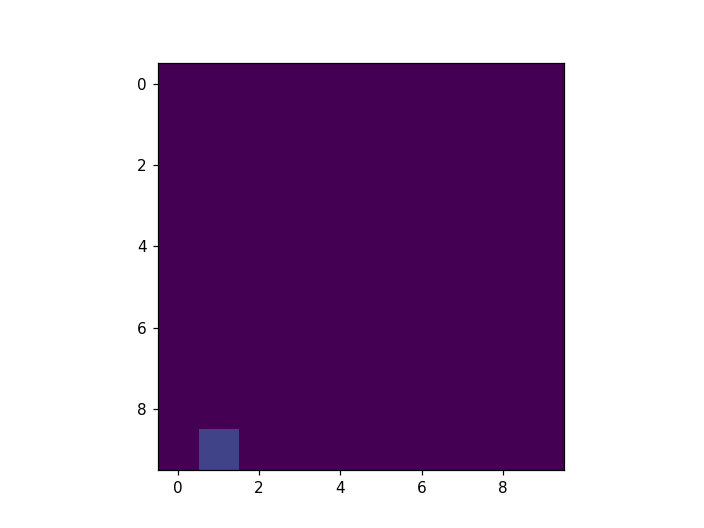

In [89]:
fig = plt.figure()
im = plt.imshow(momentum_object.render(), animated=True)
def updatefig(*args):
    position = momentum_object.get_state_action().reshape(1,4)
    predict_position = encoder(standardize_state(position)).detach()
    _predict_position = torch.round(denormalize_state(predict_position).detach())[0]
    momentum_object.step()
    im.set_array(momentum_object.render(_predict_position))
ani = FuncAnimation(fig, updatefig, interval=500, frames=100, blit=True)
plt.show()
updatefig()